# Making Figure 1

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)

In [15]:
from src.constants import ERSSTV5_PATH,NOAA_DATA_PATH, cmip6_ensemble_var
from src.plot_utils import label_subplots

In [ ]:
def get_ts_trends():
    """Get the 60 year trends over the nino3.4 region for differnt members of the nino3.4 ensemble."""
    tr_list = []
    fin_list = []
    for start, fin in [(x - 59, x) for x in range(2007, 2017)]:
        tr_list.append([])
        for i in range(len(os.listdir(CMIP6_TS_PATH))):
            ex = can_coords(
                xr.open_dataarray(CMIP6_TS_PATH / os.listdir(CMIP6_TS_PATH)[i])
            ).sel(T=slice(str(start), str(fin)))
            tr_list[-1].append(
                get_trend(spatial_mean(sel(ex, reg="nino3.4")), min_clim_f=True)
            )
        fin_list.append(fin)
    return xr.DataArray(
        tr_list,
        dims=["fin", "member"],
        coords=dict(fin=fin_list, member=os.listdir(CMIP6_TS_PATH)),
        attrs=dict(units="K", long_name="60 year trend in nino3.4"),
    )

No handles with labels found to put in legend.


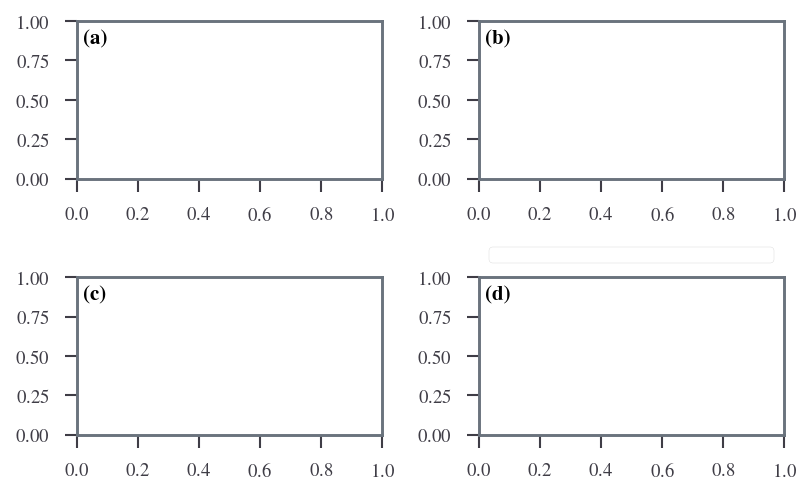

In [14]:
fig, axs = plt.subplots(2, 2)
label_subplots(axs)
plt.legend(
    bbox_to_anchor=(-0, 1.02, 1, 0.102),
    loc="lower left",
    mode="expand",
    ncol=2,
)
plt.tight_layout()